# KNN Regression

Implementasi KNN Regression untuk forecasting data time series NO2.

## 1. Import Library

Import library yang diperlukan untuk KNN Regression, termasuk pandas untuk manipulasi data, numpy untuk operasi numerik, matplotlib dan seaborn untuk visualisasi, serta scikit-learn untuk modeling dan evaluasi.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

## 2. Load Dataset Supervised

Load dataset supervised dengan lag 4 yang telah dipersiapkan sebelumnya. Dataset ini berisi nilai NO2 saat ini dan nilai-nilai lag (NO2 pada hari-hari sebelumnya).

In [2]:
df = pd.read_csv("dataset/supervised_data_lag_4.csv")
print("Shape dataset:", df.shape)
df.head()

Shape dataset: (6912, 15)


,t,NO2,t-1,t-2,t-3,t-4,year,month,day,dayofweek,dayofyear,month_sin,month_cos,day_sin,day_cos
0,2021-01-02,0.000034,0.000034,0.000034,0.000034,0.000034,2021,1,2,5,2,0.5,0.866025,0.394356,0.918958
1,2021-01-02,0.000034,0.000034,0.000034,0.000034,0.000034,2021,1,2,5,2,0.5,0.866025,0.394356,0.918958
2,2021-01-02,0.000034,0.000034,0.000034,0.000034,0.000034,2021,1,2,5,2,0.5,0.866025,0.394356,0.918958
3,2021-01-02,0.000034,0.000034,0.000034,0.000034,0.000034,2021,1,2,5,2,0.5,0.866025,0.394356,0.918958
4,2021-01-03,0.000034,0.000034,0.000034,0.000034,0.000034,2021,1,3,6,3,0.5,0.866025,0.571268,0.820763


## 3. Explorasi Data

Melihat informasi dataset meliputi tipe data, deskripsi statistik, dan pengecekan missing values untuk memastikan kualitas data sebelum modeling.

In [3]:
print("Info Dataset:")
print(df.info())
print("\nDeskripsi Statistik:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6912 entries, 0 to 6911
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   t          6912 non-null   object 
 1   NO2        6912 non-null   float64
 2   t-1        6912 non-null   float64
 3   t-2        6912 non-null   float64
 4   t-3        6912 non-null   float64
 5   t-4        6912 non-null   float64
 6   year       6912 non-null   int64  
 7   month      6912 non-null   int64  
 8   day        6912 non-null   int64  
 9   dayofweek  6912 non-null   int64  
 10  dayofyear  6912 non-null   int64  
 11  month_sin  6912 non-null   float64
 12  month_cos  6912 non-null   float64
 13  day_sin    6912 non-null   float64
 14  day_cos    6912 non-null   float64
dtypes: float64(9), int64(5), object(1)
memory usage: 810.1+ KB
None

Deskripsi Statistik:
               NO2          t-1          t-2          t-3          t-4  \
count  6912.000000  6912.000000  6

## 4. Persiapan Data untuk Modeling

### Identifikasi Kolom Dataset

Langkah pertama adalah mengidentifikasi kolom-kolom yang ada dalam dataset untuk menentukan mana yang akan menjadi target (variabel yang akan diprediksi) dan mana yang akan menjadi fitur (variabel prediktor).

In [4]:
print("Kolom dalam dataset:")
print(df.columns.tolist())

if 'NO2' in df.columns:
    target_col = 'NO2'
else:
    target_col = df.columns[-1]

print(f"\nKolom target: {target_col}")

Kolom dalam dataset:
['t', 'NO2', 't-1', 't-2', 't-3', 't-4', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'month_sin', 'month_cos', 'day_sin', 'day_cos']

Kolom target: NO2


### Pemisahan Fitur dan Target

Pada tahap ini, kita memisahkan dataset menjadi:
- **Fitur (X)**: Variabel-variabel yang akan digunakan untuk prediksi (kolom lag)
- **Target (y)**: Variabel yang akan diprediksi (kolom NO2)

Beberapa kolom dihapus dari fitur karena:
- Kolom **'t'** (timestamp): Tidak dapat dinormalisasi dan tidak relevan untuk model
- Kolom **temporal** (day, dayofweek, year, month, dayofyear): Fitur waktu yang redundan
- Kolom **siklik** (month_sin, month_cos, day_sin, day_cos): Representasi siklik yang tidak diperlukan dalam konteks ini

In [5]:
X = df.drop(
    columns=[
        target_col,
        "t",
        "day",
        "dayofweek",
        "year",
        "month",
        "dayofyear",
        "month_sin",
        "month_cos",
        "day_sin",
        "day_cos",
    ]
)
y = df[target_col]

print(f"\nShape X: {X.shape}")
print(f"Shape y: {y.shape}")
print(f"\nKolom fitur yang digunakan:")
print(X.columns.tolist())


Shape X: (6912, 4)
Shape y: (6912,)

Kolom fitur yang digunakan:
['t-1', 't-2', 't-3', 't-4']


## 5. Split Data Train dan Test

Membagi data menjadi data training (80%) dan testing (20%). Gunakan `shuffle=False` untuk menjaga urutan waktu pada data time series.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

print("Shape data train:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print("\nShape data test:")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape data train:
X_train: (5529, 4), y_train: (5529,)

Shape data test:
X_test: (1383, 4), y_test: (1383,)


## 6. Normalisasi Data

Normalisasi data menggunakan MinMaxScaler agar semua fitur memiliki skala yang sama. KNN sangat sensitif terhadap skala data, sehingga normalisasi sangat penting.

In [7]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

normalized_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
normalized_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

normalized_train.to_csv('dataset/X_train_normalized.csv', index=False)
normalized_test.to_csv('dataset/X_test_normalized.csv', index=False)

print("Data hasil normalisasi telah disimpan:")
print(f"- X_train_normalized.csv: {normalized_train.shape}")
print(f"- X_test_normalized.csv: {normalized_test.shape}")
print()
print("Data berhasil dinormalisasi")
print(f"Mean X_train_scaled: {X_train_scaled.mean():.6f}")
print(f"Std X_train_scaled: {X_train_scaled.std():.6f}")

Data hasil normalisasi telah disimpan:
- X_train_normalized.csv: (5529, 4)
- X_test_normalized.csv: (1383, 4)

Data berhasil dinormalisasi
Mean X_train_scaled: 0.460533
Std X_train_scaled: 0.076960


## 7. Training Model KNN Regression

Membuat model KNN Regression dengan parameter awal: k=3 neighbors, uniform weights, dan euclidean distance sebagai metric.

In [8]:
knn_model = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='euclidean')

knn_model.fit(X_train_scaled, y_train)

print("Model KNN Regression berhasil ditraining")
print(f"Jumlah neighbors (k): {knn_model.n_neighbors}")
print(f"Weights: {knn_model.weights}")
print(f"Metric: {knn_model.metric}")

Model KNN Regression berhasil ditraining
Jumlah neighbors (k): 5
Weights: uniform
Metric: euclidean


## 8. Prediksi pada Data Test

Melakukan prediksi pada data test dan data train menggunakan model yang telah ditraining.

In [9]:
y_pred = knn_model.predict(X_test_scaled)
y_train_pred = knn_model.predict(X_train_scaled)

print("Prediksi berhasil dilakukan")
print(f"Shape y_train_pred: {y_train_pred.shape}, Shape y_pred: {y_pred.shape}")

Prediksi berhasil dilakukan
Shape y_train_pred: (5529,), Shape y_pred: (1383,)


## 9. Evaluasi Model

Menghitung metrik evaluasi model meliputi MSE (Mean Squared Error), RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), dan R² Score untuk data training dan testing.

In [10]:
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print("EVALUASI MODEL KNN REGRESSION")
print("\nMetrik pada Data Training:")
print(f"MSE  : {mse_train:.6f}")
print(f"RMSE : {rmse_train:.6f}")
print(f"MAE  : {mae_train:.6f}")
print(f"R²   : {r2_train:.6f}")
print("\nMetrik pada Data Testing:")
print(f"MSE  : {mse_test:.6f}")
print(f"RMSE : {rmse_test:.6f}")
print(f"MAE  : {mae_test:.6f}")
print(f"R²   : {r2_test:.6f}")

EVALUASI MODEL KNN REGRESSION

Metrik pada Data Training:
MSE  : 0.000000
RMSE : 0.000007
MAE  : 0.000005
R²   : 0.555480

Metrik pada Data Testing:
MSE  : 0.000000
RMSE : 0.000008
MAE  : 0.000005
R²   : 0.381509


## 10. Visualisasi Hasil Prediksi

Visualisasi hasil prediksi dengan dua plot: perbandingan time series antara nilai aktual dan prediksi, serta scatter plot untuk melihat seberapa dekat prediksi dengan nilai aktual.

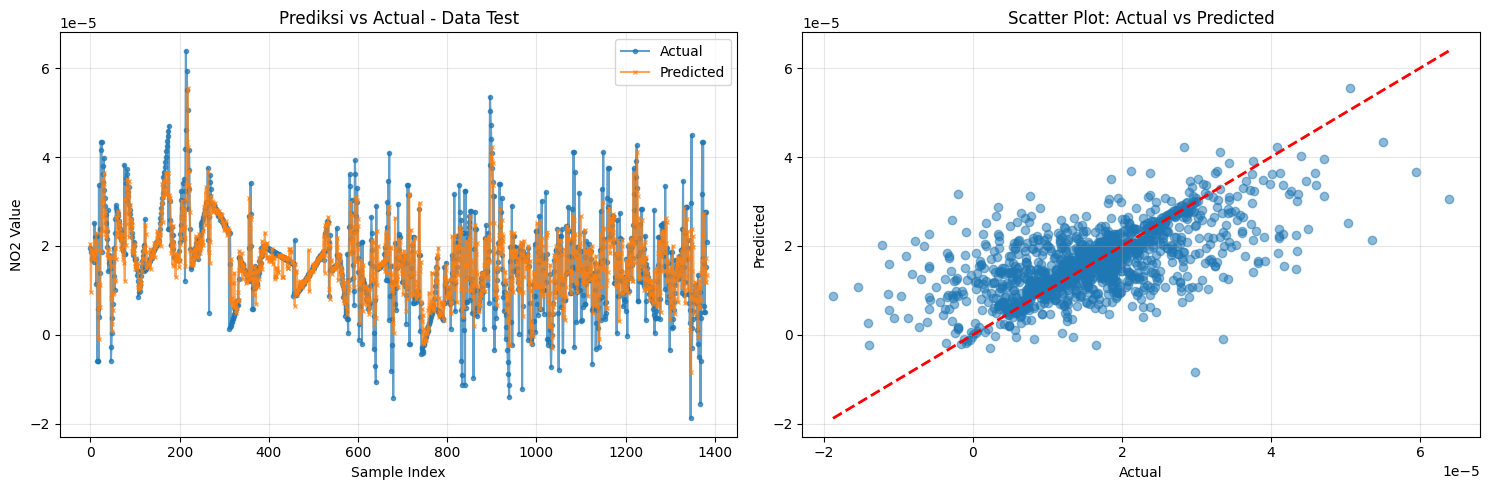

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test.values, label='Actual', marker='o', markersize=3, alpha=0.7)
plt.plot(y_pred, label='Predicted', marker='x', markersize=3, alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('NO2 Value')
plt.title('Prediksi vs Actual - Data Test')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Plot: Actual vs Predicted')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Residual Analysis

Analisis residual (selisih antara nilai aktual dan prediksi) untuk mengevaluasi kualitas model melalui residual plot, histogram distribusi residual, dan Q-Q plot untuk cek normalitas.

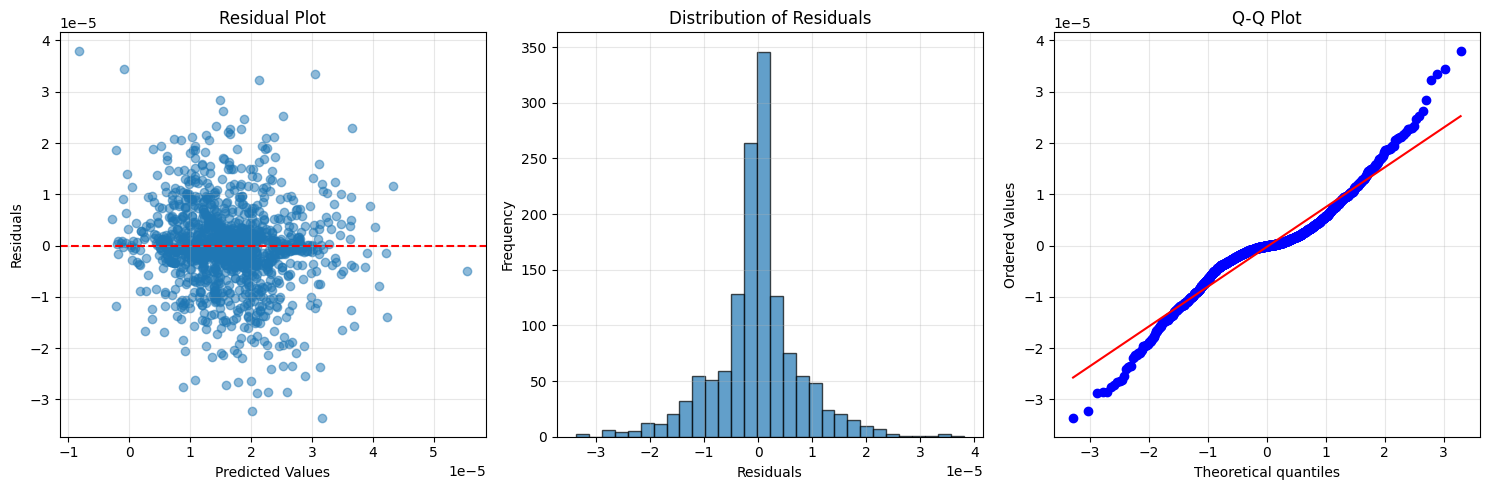

Mean Residual: -0.000000
Std Residual: 0.000008


In [12]:
residuals = y_test.values - y_pred

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

from scipy import stats
plt.subplot(1, 3, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean Residual: {residuals.mean():.6f}")
print(f"Std Residual: {residuals.std():.6f}")

## 12. Hyperparameter Tuning - Mencari K Optimal

Mencari nilai k (jumlah neighbors) optimal dengan mencoba berbagai nilai k dari 1 hingga 20, kemudian membandingkan R² Score pada data training dan testing untuk setiap nilai k.

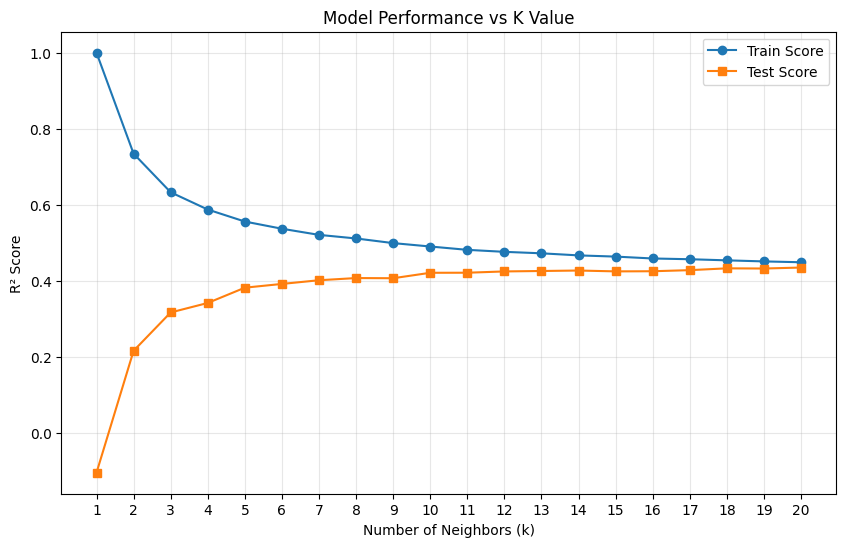


Optimal K: 20
Best Test Score (R²): 0.434482


In [13]:
k_range = range(1, 21)
train_scores = []
test_scores = []

for k in k_range:
    knn_temp = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    knn_temp.fit(X_train_scaled, y_train)
    
    train_scores.append(knn_temp.score(X_train_scaled, y_train))
    
    test_scores.append(knn_temp.score(X_test_scaled, y_test))

plt.figure(figsize=(10, 6))
plt.plot(k_range, train_scores, label='Train Score', marker='o')
plt.plot(k_range, test_scores, label='Test Score', marker='s')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('R² Score')
plt.title('Model Performance vs K Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.show()

optimal_k = k_range[np.argmax(test_scores)]
print(f"\nOptimal K: {optimal_k}")
print(f"Best Test Score (R²): {max(test_scores):.6f}")

## 13. Training Model dengan K Optimal

Melatih ulang model KNN menggunakan nilai k optimal yang telah ditemukan, kemudian mengevaluasi performanya.

In [14]:
knn_optimal = KNeighborsRegressor(n_neighbors=optimal_k, weights='uniform')
knn_optimal.fit(X_train_scaled, y_train)

y_pred_optimal = knn_optimal.predict(X_test_scaled)
y_train_pred_optimal = knn_optimal.predict(X_train_scaled)

mse_test_opt = mean_squared_error(y_test, y_pred_optimal)
rmse_test_opt = np.sqrt(mse_test_opt)
mae_test_opt = mean_absolute_error(y_test, y_pred_optimal)
r2_test_opt = r2_score(y_test, y_pred_optimal)

mse_train_opt = mean_squared_error(y_train, y_train_pred_optimal)
rmse_train_opt = np.sqrt(mse_train_opt)
mae_train_opt = mean_absolute_error(y_train, y_train_pred_optimal)
r2_train_opt = r2_score(y_train, y_train_pred_optimal)

print(f"MODEL KNN REGRESSION DENGAN K OPTIMAL = {optimal_k}")
print("\nMetrik pada Data Training:")
print(f"MSE  : {mse_train_opt:.6f}")
print(f"RMSE : {rmse_train_opt:.6f}")
print(f"MAE  : {mae_train_opt:.6f}")
print(f"R²   : {r2_train_opt:.6f}")
print("\nMetrik pada Data Testing:")
print(f"MSE  : {mse_test_opt:.6f}")
print(f"RMSE : {rmse_test_opt:.6f}")
print(f"MAE  : {mae_test_opt:.6f}")
print(f"R²   : {r2_test_opt:.6f}")

MODEL KNN REGRESSION DENGAN K OPTIMAL = 20

Metrik pada Data Training:
MSE  : 0.000000
RMSE : 0.000008
MAE  : 0.000005
R²   : 0.448405

Metrik pada Data Testing:
MSE  : 0.000000
RMSE : 0.000008
MAE  : 0.000005
R²   : 0.434482


## 14. Perbandingan Model Default vs Optimal

Membandingkan performa model default (k=5) dengan model optimal untuk melihat peningkatan performa setelah hyperparameter tuning.

In [15]:
comparison = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Default (k=5) - Train': [mse_train, rmse_train, mae_train, r2_train],
    'Default (k=5) - Test': [mse_test, rmse_test, mae_test, r2_test],
    f'Optimal (k={optimal_k}) - Train': [mse_train_opt, rmse_train_opt, mae_train_opt, r2_train_opt],
    f'Optimal (k={optimal_k}) - Test': [mse_test_opt, rmse_test_opt, mae_test_opt, r2_test_opt]
})

print("\nPerbandingan Model:")
print(comparison.to_string(index=False))


Perbandingan Model:
Metric  Default (k=5) - Train  Default (k=5) - Test  Optimal (k=20) - Train  Optimal (k=20) - Test
   MSE           4.571598e-11          6.345120e-11            5.672789e-11           5.801671e-11
  RMSE           6.761359e-06          7.965626e-06            7.531792e-06           7.616870e-06
   MAE           4.521927e-06          5.305459e-06            4.957578e-06           4.922053e-06
    R²           5.554797e-01          3.815091e-01            4.484051e-01           4.344819e-01


## 15. Visualisasi Hasil Model Optimal

Visualisasi hasil prediksi model optimal dengan time series plot dan scatter plot untuk mengevaluasi kualitas prediksi secara visual.

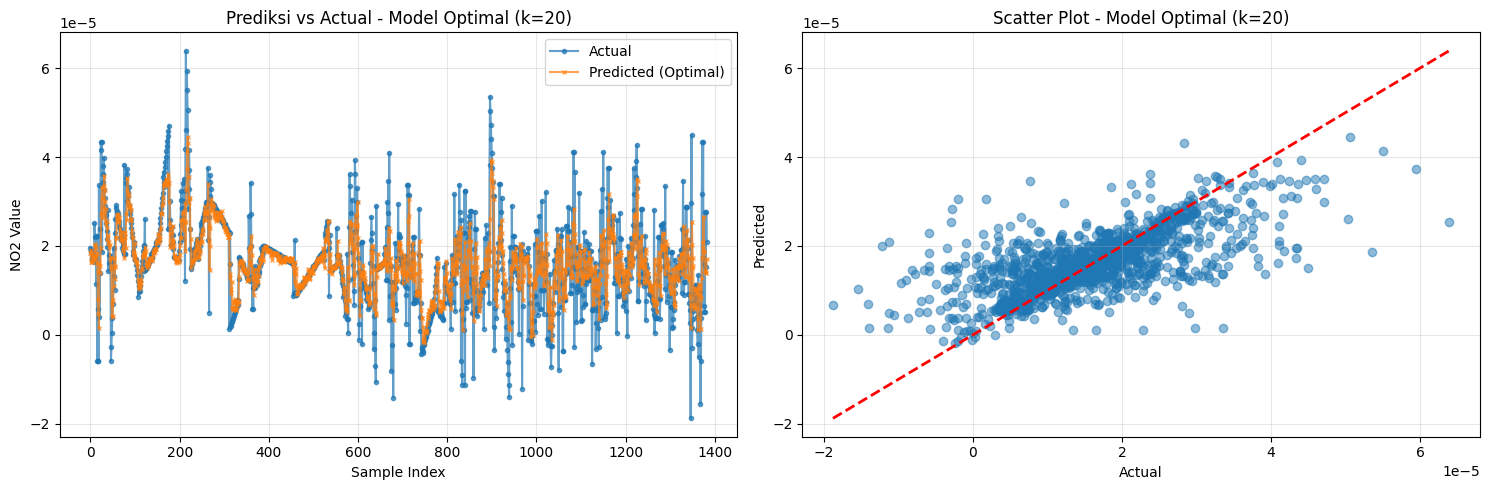

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(y_test.values, label='Actual', marker='o', markersize=3, alpha=0.7)
plt.plot(y_pred_optimal, label='Predicted (Optimal)', marker='x', markersize=3, alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('NO2 Value')
plt.title(f'Prediksi vs Actual - Model Optimal (k={optimal_k})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_optimal, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Scatter Plot - Model Optimal (k={optimal_k})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()